In [341]:
# -*- coding: UTF-8 -*-
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import pymongo
import pandas as pd 
import numpy as np
import pickle


from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from konlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from scipy.sparse import vstack

from sklearn.metrics import accuracy_score

<h3>Predict Train Data</h3>

In [342]:
df_2 = pd.read_excel("mnet_music7.xlsx")

In [343]:
df_2.columns

Index(['순위', '곡명', '가수', '작곡', '작사', '피쳐링', '년월', '발매일', '음악장르', '재생시간', '좋아요',
       '편곡', '활동유형', '작곡1', '작곡2', '작곡3', '작곡4', '작곡5', '작곡6', '작곡7', '작곡8',
       '작곡9', '작곡10', '작곡11', '작곡12', '작사1', '작사2', '작사3', '작사4', '작사5', '작사6',
       '작사7', '작사8', '작사9', '작사10', '작사11', '작사12', '가수1', '가수2', '가수3', '가수4',
       '가수5', '가수6', '가수7', '가수8', '가수9', '가수10', '가수11'],
      dtype='object')

In [344]:
df_2.head(2)

,순위,곡명,가수,작곡,작사,피쳐링,년월,발매일,음악장르,재생시간,...,가수2,가수3,가수4,가수5,가수6,가수7,가수8,가수9,가수10,가수11
0,1위,Gee,소녀시대,이트라이브,이트라이브,없음,200901,2009.01.05,댄스 > 댄스,03:22,...,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음
1,2위,이젠 남이야 (Feat. Baby-J of Jewelry),김경록,조영수,조영수,Baby-J,200901,2008.12.16,가요 > 알앤비,04:07,...,없음,없음,없음,없음,없음,없음,없음,없음,없음,없음


In [345]:
df_2['순위_2'] = df_2['순위'].apply(lambda x: float(x[:-1]))
df_2['순위_4'] = df_2['순위_2'].apply(lambda x : True if x <= 10 else False) #(df_2['순위_2']-1)/10

In [346]:
# 작곡, 가수의 공백 제거
df_2['가수1_rb'] = df_2['가수1'].apply(lambda x: str(x).replace(" ", ""))
df_2['작곡1_rb'] = df_2['작곡1'].apply(lambda x: str(x).replace(" ", ""))

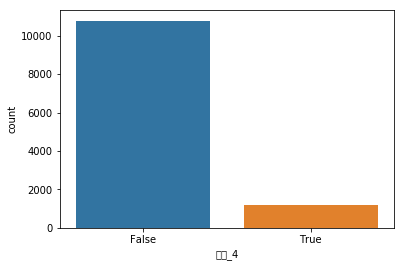

In [347]:
import seaborn as sns
sns.countplot(df_2['순위_4'])

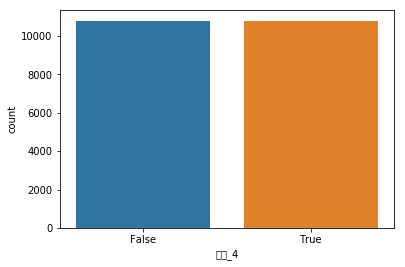

In [348]:
#class 분포가 너무 치우쳐져 있다. => false라고만 대답하면 90프로는 맞는다.. 
# 분포를 맞추기 위해 복사함 10위 안 데이터를 
import seaborn as sns
train_top_10 = df_2[df_2['순위_2'] <= 10]

for i in range(8):
    df_2 = pd.concat([df_2, train_top_10])
    
sns.countplot(df_2['순위_4'])

In [349]:
# train test 나누기

# random idx 뽑기
test_idx = np.random.choice(len(df_2), 5000, replace=False)
train_idx = list({i for i in range(len(df_2))} - set(test_idx))

train = df_2.iloc[train_idx]
test = df_2.iloc[test_idx]

In [350]:
print(len(train))
print(len(test))

16571
5000


In [351]:
# train vectorize
vectorizer_singer =  TfidfVectorizer(ngram_range=(1,1))
vectorizer_pd =  TfidfVectorizer(ngram_range=(1,1))

singer_vec = vectorizer_singer.fit_transform(train['가수1_rb'])
pd_vec = vectorizer_pd.fit_transform(train['작곡1_rb'])

In [352]:
# 가수 , 작곡 각각 feature 수(사전)
print(len(vectorizer_singer.get_feature_names()))
print(len(vectorizer_pd.get_feature_names()))

898
1115


In [353]:
# 두 sparse matrix(가수, 작곡) 합치기
from scipy import sparse
singer_pd_vec = hstack((singer_vec, pd_vec))
singer_pd_vec

<16571x2013 sparse matrix of type '<class 'numpy.float64'>'
	with 32886 stored elements in COOrdinate format>

In [354]:
train_x = singer_pd_vec
train_y = train['순위_4']

In [362]:
model_rf = RandomForestClassifier(n_estimators=500, max_depth=10).fit(train_x, train_y)



In [431]:
from sklearn.linear_model import SGDClassifier
model_rf = LogisticRegression().fit(train_x, train_y)

In [432]:
pred_train = model_rf.predict(train_x)
accuracy_score(train['순위_4'], pred_train)

0.7371311327017078

In [433]:
from sklearn.metrics import classification_report
print(classification_report(train_y, pred_train))

             precision    recall  f1-score   support

      False       0.80      0.63      0.71      8292
       True       0.70      0.84      0.76      8279

avg / total       0.75      0.74      0.73     16571



<h3>2. Predict Test data  </h3>

In [434]:
# train vectorizer 활용 tfidf 
feature_list_singer = vectorizer_singer.get_feature_names()
feature_list_pd = vectorizer_pd.get_feature_names()

test_vectorizer_singer =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_singer)
test_vectorizer_pd =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_pd)

test_vec_singer = test_vectorizer_singer.fit_transform(test['가수1'])
test_vec_pd = test_vectorizer_pd.fit_transform(test['작곡1'])

test_x = hstack((test_vec_singer, test_vec_pd))
test_y = test['순위_4']

In [435]:
print(train_x.shape)
print(test_x.shape)

(16571, 2013)
(5000, 2013)


In [436]:
pred_test = model_rf.predict(test_x)
accuracy_score(test_y, pred_test)

0.6842

In [399]:
print(classification_report(test['순위_4'], pred_test))

             precision    recall  f1-score   support

      False       0.62      0.73      0.67      2488
       True       0.67      0.55      0.61      2512

avg / total       0.64      0.64      0.64      5000



In [46]:
model_rf.feature_importances_[model_rf.feature_importances_ >= 0.02]

array([0.03171098, 0.02510437, 0.04420039, 0.02351822, 0.02194109,
       0.02691338, 0.07222553])

In [90]:
test_vectorizer_singer.get_feature_names()

902

In [121]:
# sum(model_rf.feature_importances_ >= 0.017)

# import_features_idx = np.where(model_rf.feature_importances_ >= 0.017)

# import_features_idx

# print(len(vectorizer_singer.get_feature_names()))
# print(len(vectorizer_pd.get_feature_names()))

# np.array(vectorizer_singer.get_feature_names())[[,  349,  516]]


# np.array(vectorizer_pd.get_feature_names())[[1237-902, 1339-902, 1539-902, 1615-902, 1653-902]]

<h3>3. Predict User Input Data </h3>

In [486]:
singer = '지코'
producer = '아이유'

In [487]:
singer = str(singer).replace(" ", "")
producer = str(producer).replace(" ", "")

In [488]:
user_x = {"가수":[singer], "작곡": [producer]}

In [489]:
user_x = pd.DataFrame(user_x, columns=["가수","작곡"])

In [490]:
feature_list_singer = vectorizer_singer.get_feature_names()
feature_list_pd = vectorizer_pd.get_feature_names()

user_vectorizer_singer =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_singer)
user_vectorizer_pd =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_pd)

In [491]:
user_vec_singer = user_vectorizer_singer.fit_transform(user_x['가수'])
user_vec_pd = user_vectorizer_pd.fit_transform(user_x['작곡'])
user_x = hstack((user_vec_singer, user_vec_pd))

In [492]:
pred_user = model_rf.predict(user_x)

In [493]:
print(pred_user[0])

True


In [494]:
model_rf.predict_proba(user_x)

array([[0.49385593, 0.50614407]])

<h3>4. Pickle 활용</h3>

In [285]:
len(feature_list_singer)
len(feature_list_pd)

1100

In [311]:
import pickle

with open('feature_list_singer_2.txt','wb') as f:
    pickle.dump(feature_list_singer,f)

with open('feature_list_pd_2.txt', 'wb') as f:
    pickle.dump(feature_list_pd, f)

In [312]:
with open('feature_list_singer_2.txt','rb') as f:
    feature_list_singer_2=pickle.load(f)   
    
with open('feature_list_pd_2.txt','rb') as f:
    feature_list_pd_2=pickle.load(f)         

In [324]:
singer = '홍다희'
producer = '이대환'

In [325]:
singer = str(singer).replace(" ", "")
producer = str(producer).replace(" ", "")

user_x = {"가수":[singer], "작곡": [producer]}
user_x = pd.DataFrame(user_x, columns=["가수","작곡"])

feature_list_singer = vectorizer_singer.get_feature_names()
feature_list_pd = vectorizer_pd.get_feature_names()

user_vectorizer_singer =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_singer_2)
user_vectorizer_pd =  TfidfVectorizer(ngram_range=(1,1), vocabulary = feature_list_pd_2)

user_vec_singer = user_vectorizer_singer.fit_transform(user_x['가수'])
user_vec_pd = user_vectorizer_pd.fit_transform(user_x['작곡'])
user_x = hstack((user_vec_singer, user_vec_pd))

#
pred_user = model_rf.predict(user_x)
print(pred_user[0])

False


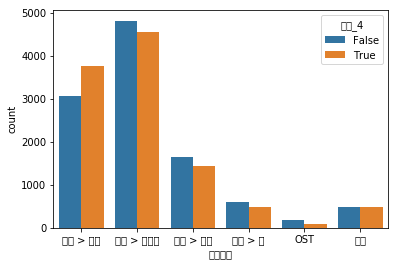

In [336]:
sns.countplot(df_2['음악장르'], hue=df_2['순위_4'])

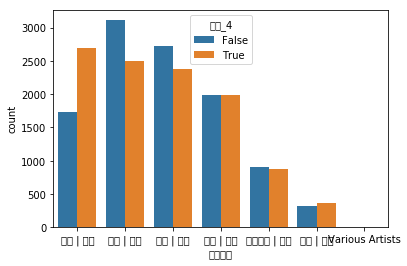

In [337]:
sns.countplot(df_2['활동유형'], hue=df_2['순위_4'])